# Plots to analyze and understand our data

Start by importing necessary libraries:

In [2]:
import csv
from collections import defaultdict
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from DATASET import clean_df

Import all relevant files, as well as our merged dataset: 

In [3]:
file1 = './Students/Estudiants_èxit_accés_anònim.csv'
file2 = './Students/Estudiants_notes_assignatures_anònim.csv'
file3 = './Students/Estudiants_abandonament_anònim.csv'

## 1. Histogram of final grades

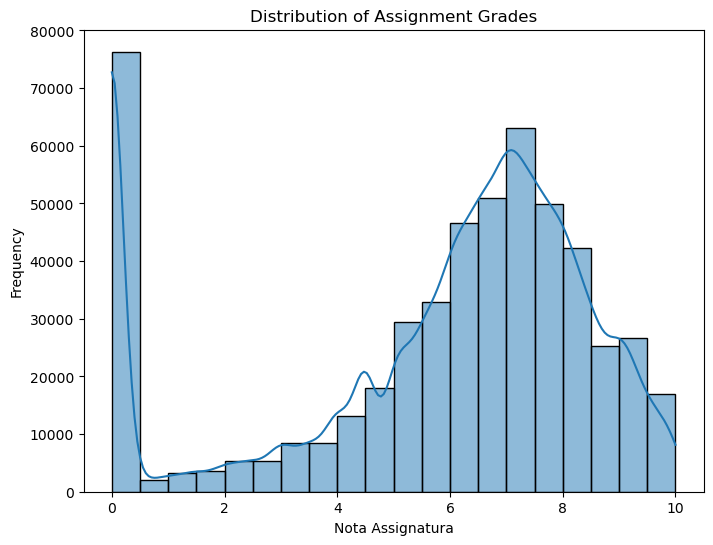

In [4]:
plt.figure(figsize=(8, 6))
sns.histplot(clean_df['nota_assignatura'], kde=True, bins=20)
plt.title('Distribution of Assignment Grades')
plt.xlabel('Nota Assignatura')
plt.ylabel('Frequency')
plt.show()



 > From the plot, we can see that there are many cases where students received a grade of 0. While the most common grades lie in the range between 4 and 10. We should inspect where all these zeros come from, if they are really student's marks or if they are related to other factors such as drop out.



## 2. Identifying clusters in the data
This code will cluster students based on their background data and grades, and then compare the clusters. We will use KMeans clustering to group students based on their background and grades. We will also visualize the clusters using PCA for dimensionality reduction.

In [5]:
df_background = pd.read_csv(file1)

# Select and preprocess relevant features
df_background_filtered = df_background[[  
    'Id Anonim',
    'Sexe',
    'Via Accés Estudi',
    'Nota d\'accés (preinscripció)',
    'Dedicació de l\'estudiant',
    'Beca Concedida?',
]].dropna(subset=['Nota d\'accés (preinscripció)'])  # Ensure valid grades

# One-hot encode categorical variables
# Primero cargamos de nuevo el dataframe procesado
df = df_background_filtered.copy()

#### 1st Grouping: Id Anonim vs Nota d'accés

In [6]:
# we use DBSCAN to group closer grades
marks_scaler = StandardScaler()
scaled_marks = marks_scaler.fit_transform(df[['Nota d\'accés (preinscripció)']])

dbscan_marks = DBSCAN(eps=0.05, min_samples=1)  # small eps for similar marks
marks_clusters = dbscan_marks.fit_predict(scaled_marks)

# Save grades cluster
df['Cluster_same_grade'] = marks_clusters

#### 2nd Grouping: Id Anonim vs Características sociodemográficas

In [7]:
# Select characteristics to group
features = [
    'Beca Concedida?', 
    'Via Accés Estudi', 
    'Sexe',
    'Dedicació de l\'estudiant'
]

# encode categorical variables
df_features_encoded = pd.get_dummies(df[features], drop_first=True)

# Scale features
scaler_features = StandardScaler()
features_scaled = scaler_features.fit_transform(df_features_encoded)

# Clustering based on sociodemographic similarities
dbscan_features = DBSCAN(eps=0.5, min_samples=1)
clusters_features = dbscan_features.fit_predict(features_scaled)

# Save sociodemographical clustering
df['Cluster_profile'] = clusters_features

#### Result

In [8]:
# Show final dataframe
print(df[['Id Anonim', 'Nota d\'accés (preinscripció)', 'Cluster_same_grade', 'Cluster_profile']])

df_unique = df.drop_duplicates(subset=['Id Anonim'])

sns.set_theme(style="whitegrid")

                             Id Anonim  Nota d'accés (preinscripció)  \
0     1DFB71F2B000D1421808D0B3F67B335E                        10.798   
1     C26BD2D93ECB81CCB559D5B01B51475B                         6.512   
2     7526FB10E35C2E8808213E923F8F6125                        11.468   
3     FE20EBA7DC6B312D1F2FEA0A76D8E32D                        10.102   
4     22F995020F697929585BBADAC92CAB20                        10.870   
...                                ...                           ...   
5049  1DD45B64CD99F09F05CFD1494A2759D8                        10.306   
5050  B00599E75FAEA4201E19D6423F7A586F                        11.170   
5051  43E857A43F0C47B06C897EE1B5420859                        11.326   
5052  AB84122CC95E9606BF1105B1493AF177                        10.894   
5053  561BCC27E5BF6BF4318B71754314D3F2                         0.000   

      Cluster_same_grade  Cluster_profile  
0                      0                0  
1                      0                1  
2  

#### First Plot: Grouping by marks

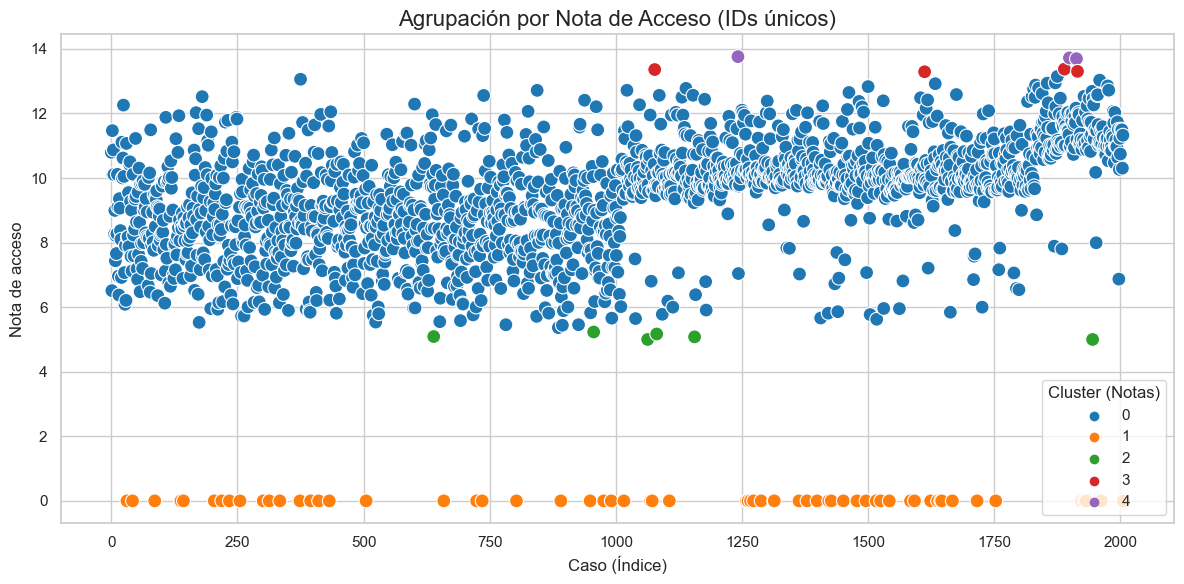

In [9]:
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x=range(len(df_unique)),  # índice limpio
    y='Nota d\'accés (preinscripció)',
    hue='Cluster_same_grade',
    palette='tab10',
    data=df_unique,
    s=100
)
plt.title('Agrupación por Nota de Acceso (IDs únicos)', fontsize=16)
plt.xlabel('Caso (Índice)')
plt.ylabel('Nota de acceso')
plt.legend(title='Cluster (Notas)')
plt.tight_layout()
plt.show()

#### Second Plot: Sociodemographical Profile

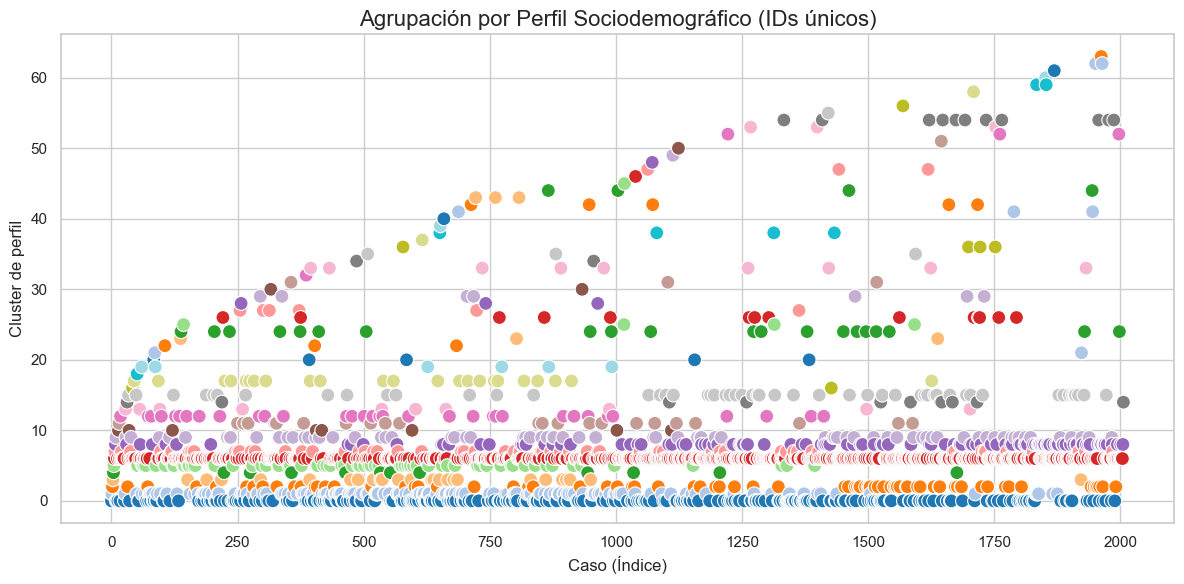

In [10]:
plt.figure(figsize=(12, 6))
ax = sns.scatterplot(
    x=range(len(df_unique)),  
    y='Cluster_profile',
    hue='Cluster_profile',
    palette='tab20',
    data=df_unique,
    s=100
)
plt.title('Agrupación por Perfil Sociodemográfico (IDs únicos)', fontsize=16)
plt.xlabel('Caso (Índice)')
plt.ylabel('Cluster de perfil')
ax.legend_.remove()  # <-- REMOVED THE LEGEND SO THAT THE PLOT FITS!
plt.tight_layout()
plt.show()

## 3. Applying PCA in order to visualize our data

Here we will be working with our merged dataframe, our goal is to visualize its structure, in order to do so, we will reduce its dimensions to 3 principal components using PCA, and plot them in order to have some general idea about how our data looks like.

Since PCA can only be applied on numerical features, we will analyze which features in our dataframe are already numerical and which other features can be encoded with numerical values:

In [11]:
clean_df.dtypes

estudi                       object
curs_academic                object
id_anonim                    object
sexe                         object
assignatura                  object
codi_assignatura              int64
nota_assignatura            float64
via_acces_estudi             object
nota_d_acces                float64
dedicacio_de_l_estudiant     object
discapacitat                 object
beca_concedida               object
estudis_mare                 object
estudis_pare                 object
taxa_exit                   float64
abandonament                  int64
dtype: object